# Análise de Dados Exploratória da ANAC

![ANAC](imgs/anac-logo.png "Logo ANAC")

# 1. Introdução

Este estudo tem como objetivo analisar um conjunto de dados de voos internacionais registrados pela Agência Nacional de Aviação Civil (ANAC) do Brasil, durante o período de janeiro de 2015 a agosto de 2017. 

A ANAC é a agência reguladora responsável pela aviação civil no país, e as informações contidas nesses dados são de grande importância para a compreensão da dinâmica da aviação internacional no Brasil, bem como para a tomada de decisões estratégicas no setor. O conjunto de dados inclui informações como o número do voo, nome da companhia aérea, horários de partida e chegada previstos e reais, situação do voo e localização dos aeroportos de origem e destino, entre outros. Esses dados permitem uma análise detalhada das tendências e padrões de voos internacionais no Brasil, bem como a identificação de fatores que possam influenciar o desempenho da aviação internacional no país.

## 1.1. Objetivos

O objetivo deste estudo é realizar uma Análise Exploratória dos Dados (Exploratory Data Analysis - EDA) do conjunto de dados disposto em [bases/](bases/), e analisar dados de voos internacionais rastreados pela ANAC.

Com base nas informações disponíveis, pretendemos avaliar o desempenho das companhias aéreas em relação ao cumprimento dos horários previstos de partida e chegada, bem como investigar a frequência de cancelamentos e as justificativas apresentadas para esses casos. 

Também vamos examinar as rotas mais utilizadas e os destinos mais comuns para os voos internacionais saindo do Brasil, bem como avaliar a pontualidade e a eficiência dos aeroportos de origem e destino. 

1. [Qual destino mais procurado nas férias?](#analisedados.1)
2. [Principais destinos nacionais julho, dezembro e janeiro](#Análise2)
3. [Principais destinos internacionais julho, dezembro e janeiro.](#Análise3)
4. [Análise 4](#Análise4)


# 2. Metodologia

Nesta seção será apresentado todo o processo de preparação, organização e limpeza de dados feito no *dataset* que possui os seguintes dados brutos. Ao final desta, apresentaremos os dados padronizados e devidamente tratados:

|        Coluna        | Tipo |                         Descrição                         |
|:--------------------:|:----:|:---------------------------------------------------------:|
|         Voos         |  str |                       Número do voo                       |
|    Companhia.Aerea   |  str |                  Nome da companhia aérea                  |
|   Codigo.Tipo.Linha  |  str |          Código do tipo de linha (internacional)          |
|   Partida.Prevista   |  str |                Horário previsto de partida                |
|     Partida.Real     |  str |                  Horário real de partida                  |
|   Chegada.Prevista   |  str |                Horário previsto de chegada                |
|     Chegada.Real     |  str |                  Horário real de chegada                  |
|     Situacao.Voo     |  str |        Situação do voo (realizado, cancelado, etc)        |
| Codigo.Justificativa |  str | Código de justificativa (caso o voo tenha sido cancelado) |
|   Aeroporto.Origem   |  str |               Código do aeroporto de origem               |
|     Cidade.Origem    |  str |                      Cidade de origem                     |
|     Estado.Origem    |  str |                      Estado de origem                     |
|      Pais.Origem     |  str |                       País de origem                      |
|   Aeroporto.Destino  |  str |               Código do aeroporto de destino              |
|    Cidade.Destino    |  str |                     Cidade de destino                     |
|    Estado.Destino    |  str |                     Estado de destino                     |
|     Pais.Destino     |  str |                      País de destino                      |
|       LongDest       |  str |             Longitude do aeroporto de destino             |
|        LatDest       |  str |              Latitude do aeroporto de destino             |
|       LongOrig       |  str |              Longitude do aeroporto de origem             |
|        LatOrig       |  str |              Latitude do aeroporto de origem              |


## 2.1. Configuração do Ambiente

### 2.1.1. Bibliotecas e Ferramentas Necessárias (Built-ins)

1. ```os```:       Para manipular os arquivos de base e seus respectivos diretórios de forma multiplataforma e eficiente.
2. ```re```:       Utilizado em expressões regulares durante o processo de limpeza dos dados.
3. ```enum```:     Auxilia nos processos de padronizar e regular algumas convenções do projeto.
4. ```datetime```: Auxilia nos processos de padronizar e regular algumas convenções do projeto

### 2.1.2. Bibliotecas e Ferramentas Necessárias (pip)

1. Pandas: Para manipular e exibir os dados de forma coesa e relata.   
    ```pip install pandas```       
    ```import pandas as pd```

2. JinJa2: Complemento de estilização do Pandas.   
    ```pip install Jinja2```

3. Matplotlib: Para exibição visual dos dados por meio de gráficos.   
    ```pip install matplotlib```   
    ```import matplotlib.pyplot as plt```

4. DescricaoColuna e DescricaoTipo: São classes estáticas compostar por Enums estabelecidos com base nas convenções de nome das colunas do *dataset*.   
   **Utils** possui complementos para tratativas de alguns campos.   
    ```from libs.utils import Utils```

### 2.1.3. Importações gerais para o projeto

In [1]:
import os
import re
import time
import pandas as pd
import numpy as np
from libs.utils import Utils, Plot, AnacVoos

## 2.2. Carregamento da base

In [2]:
caminho = os.path.join(
    os.path.dirname(
        os.path.abspath(
            os.path.join(__name__, '.'))), 'bases')

arquivos = [arquivo for arquivo in os.listdir(
    caminho) if arquivo.endswith(".csv")]

dataframes = [pd.read_csv(os.path.join(caminho, arquivo))
              for arquivo in arquivos]

AnacVoos.dados = pd.concat(dataframes)
AnacVoos.total_arquivos = len(arquivos)
AnacVoos.dados_solidos = False
AnacVoos.total_registros = len(AnacVoos.dados.index)
AnacVoos.tempo_execucao = time.time()

## 2.3. Organização e Limpeza dos Dados

### 2.3.1. Padrozinação dos nomes das colunas

In [3]:
nomes_colunas_tratadas = []

for coluna in AnacVoos.dados.columns:
    if any(char.isupper() for char in coluna):
        if coluna == 'Voos':
            coluna = 'Num.Voo'
        nomes_colunas_tratadas.append('_'.join(word.lower() for word in re.findall(
            '[A-Z][^A-Z]*', coluna)).lower().replace('.', ''))

AnacVoos.dados.columns = nomes_colunas_tratadas

### 2.3.2. Padrozinação dos tipos das colunas de data/hora, string e númericos

In [4]:
for coluna in AnacVoos.dados.columns:
    tipo = Utils.tipo_coluna(coluna)
    if tipo.__name__ == 'datetime': 
        AnacVoos.dados = Utils.formatar_colunas_datetime(AnacVoos.dados, coluna)

### 2.3.3. Padrozinação no nome das companhias aérea.

In [5]:
AnacVoos.dados['companhia_aerea'] = AnacVoos.dados.apply(
    lambda row: Utils.nome_companhia_aerea_normalizado(
        row['companhia_aerea'],
    ), axis=1)

### 2.3.4. Feature Engineering
A engenharia de recursos (*Feature Engineering*) é o processo de usar o conhecimento do domínio para extrair recursos dos dados brutos. Neste estudo serão acrescentadas as seguintes colunas para enriquecer a análise de dados:

| Coluna         | Descrição                                                            | Base         |
|:--------------:|:--------------------------------------------------------------------:|:--------------:|
| partida_atrasou | Houve atraso na partida (S/N)                                       | `partida_prevista - partida_real` |
| chegada_atrasou | Houve atraso na chegada (S/N)                                       | `chegada_prevista - chegada_real` |
| distancia_km   | Distância total em kms da origem ao destino                          | `lat_long_orig - lat_long_dest` |
| justificativa_atraso   | Informação e correlata à justificativa no atraso do voo      | `codigo_justificativa` |
| justificativa_cancelamento   | Informação e correlata à justificativa do cancelamento do voo| `codigo_justificativa` |
| rota           | Origem x Destino                                                     | `cidade_origem + cidade_destino` |
| periodo_ferias           | Contém o mês condizente a um período de férias (Janeiro, Julho ou Dezembro)    | `partida_prevista` **in** [1, 7, 12]  |
| Dia Semana           | Contém o dia da semana para data de partida    | `partida_prevista`  |

#### 2.3.3.1. Atraso na partida

In [6]:
AnacVoos.dados['partida_atrasou'] = AnacVoos.dados.apply(
    lambda row: Utils.validar_atraso(
        row['situacao_voo'],
        row['partida_prevista'],
        row['partida_real']
    ), axis=1)

#### 2.3.3.2. Atraso na chegada

In [7]:
AnacVoos.dados['chegada_atrasou'] = AnacVoos.dados.apply(
    lambda row: Utils.validar_atraso(
        row['situacao_voo'],
        row['chegada_prevista'],
        row['chegada_real']
    ), axis=1)

#### 2.3.3.3. distancia_km (para *lat_long_orig* e *lat_long_dest*)

In [8]:
AnacVoos.dados['distancia_km'] = AnacVoos.dados.apply(
    lambda row: Utils.calcular_distancia_km(
        row['lat_orig'],
        row['long_orig'],
        row['lat_dest'],
        row['long_dest']
    ), axis=1)

#### 2.3.3.4. Justificativa atraso

In [9]:
AnacVoos.dados['justificativa_atraso'] = ''
AnacVoos.dados['justificativa_atraso'] = np.where(
    ((AnacVoos.dados['partida_atrasou'] == 'S') |
     (AnacVoos.dados['chegada_atrasou'] == 'S')),
    AnacVoos.dados.apply(lambda row: Utils.motivo_atraso(
        row['codigo_justificativa']), axis=1),
    AnacVoos.dados['justificativa_atraso']
)

#### 2.3.3.5. Justificativa cancelamento

In [10]:
AnacVoos.dados['justificativa_cancelamento'] = ''
AnacVoos.dados['justificativa_cancelamento'] = np.where(
    AnacVoos.dados['situacao_voo'] == 'Cancelado',
    AnacVoos.dados.apply(lambda row: Utils.motivo_cancelamento(
        row['codigo_justificativa']), axis=1),
    AnacVoos.dados['justificativa_cancelamento']
)

#### 2.3.3.6. Rota

In [11]:
AnacVoos.dados = AnacVoos.dados.assign(
    rota=AnacVoos.dados['cidade_origem'] + ' - ' + AnacVoos.dados['cidade_destino'])

#### 2.3.3.7. Período Férias

In [12]:
AnacVoos.dados['periodo_ferias'] = Utils.atribuir_periodo_ferias(AnacVoos.dados['partida_prevista'])

#### 2.3.3.8. Dia Semana

In [13]:
AnacVoos.dados['dia_semana'] = pd.to_datetime(AnacVoos.dados['partida_prevista'], dayfirst=True).dt.strftime('%A')

AnacVoos.dados['dia_semana'] = AnacVoos.dados['dia_semana'].apply(
    lambda row : Utils.atribuir_dia_semana(row)
)

## 2.4. Mapeamento de Dados
Para melhorar a análise e interpretação dos dados os seguintes atributos serão modificados:

| Coluna    | Original     | Modificado                          |
|:----------:|:-------------:|:------------------------------------:|
| *    | 'NA', *      | '', *                  |
| *      | np.NaN / NaN      | ''                  |


### 2.4.1. Removendo 'N/I' por um valor ''/string.empty

In [14]:
for coluna in AnacVoos.dados.columns:
    AnacVoos.dados[coluna] = AnacVoos.dados[coluna].replace('N/I', '')

### 2.4.2. Removendo np.NaN por um valor None

In [15]:
AnacVoos.dados.fillna(value='', inplace=True)

### 2.5. Reordenando as colunas de forma semântica

In [16]:
AnacVoos.dados = AnacVoos.dados.reindex(
    columns=Utils.nomes_colunas(), index=None)
AnacVoos.dados.drop('codigo_justificativa', axis=1, inplace=True)

# garantindo que não houveram alterações no volume de dados
AnacVoos.dados_solidos = len(AnacVoos.dados.index) == AnacVoos.total_registros

### 2.6 Resultado final

In [17]:
columns = ['NomeColuna', 'DescricaoColuna', 'TipoColuna']
values = [[value, Utils.descricao_coluna(value), Utils.tipo_coluna(
    value).__name__] for value in AnacVoos.dados.columns]

pd.DataFrame(data=values, columns=columns).style.set_table_styles([
    dict(selector='th', props=[('text-align', 'center')]),
    dict(selector='td', props=[('text-align', 'center')])
])

,NomeColuna,DescricaoColuna,TipoColuna
0,num_voo,Número do voo,str
1,companhia_aerea,Nome da companhia aérea,str
2,codigo_tipo_linha,Código do tipo de linha (internacional),str
3,rota,Origem x Destino,str
4,periodo_ferias,"Contém o mês condizente a um período de férias (Janeiro, Julho ou Dezembro)",str
5,dia_semana,Contém o dia da semana para data de partida,str
6,aeroporto_origem,Código do aeroporto de origem,str
7,cidade_origem,Cidade de origem,str
8,estado_origem,Estado de origem,str
9,pais_origem,País de origem,str


# 3. Análise dos Dados

## 3.1. Qual destino mais procurado nas férias?
Iremos analisar os principais destinos internacionais e nacionais e os períodos de julho, dezembro e janeiro.

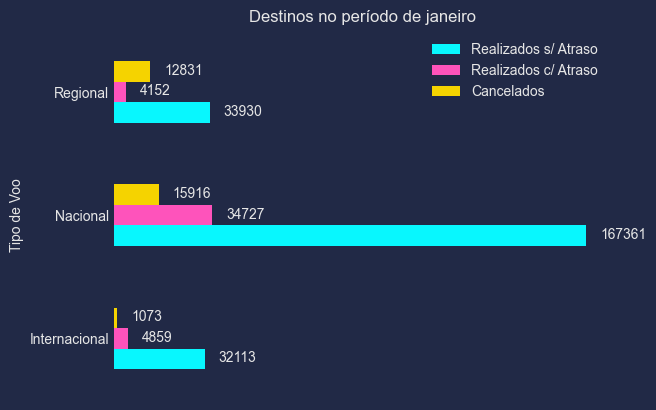

,codigo_tipo_linha,periodo_ferias,realizados_s_atraso,realizados_c_atraso,cancelados
0,Internacional,janeiro,32113,4859,1073
1,Nacional,janeiro,167361,34727,15916
2,Regional,janeiro,33930,4152,12831


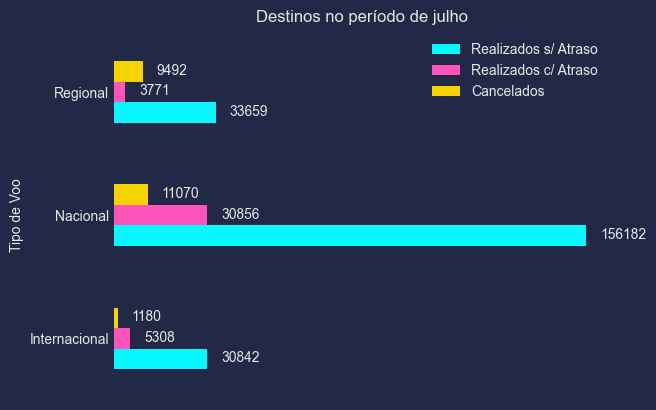

,codigo_tipo_linha,periodo_ferias,realizados_s_atraso,realizados_c_atraso,cancelados
0,Internacional,julho,30842,5308,1180
1,Nacional,julho,156182,30856,11070
2,Regional,julho,33659,3771,9492


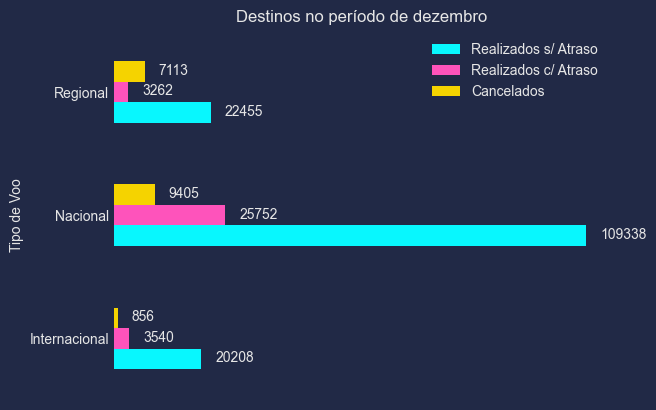

,codigo_tipo_linha,periodo_ferias,realizados_s_atraso,realizados_c_atraso,cancelados
0,Internacional,dezembro,20208,3540,856
1,Nacional,dezembro,109338,25752,9405
2,Regional,dezembro,22455,3262,7113


In [18]:
#Dataframe
voos_ferias = AnacVoos.dados[AnacVoos.dados['periodo_ferias'] != '']
periodos = voos_ferias['periodo_ferias'].unique()

voos_ferias_agg = voos_ferias.groupby(['codigo_tipo_linha', 'periodo_ferias']).agg(
    realizados_s_atraso=('situacao_voo', lambda x: (x == 'Realizado').sum()),
    realizados_c_atraso=('partida_atrasou', lambda x: (x == 'S').sum()),
    cancelados=('situacao_voo', lambda x: (x == 'Cancelado').sum())
).reset_index()

for periodo in periodos:
    df_query = voos_ferias_agg.query("periodo_ferias == @periodo").reset_index(drop=True)
    
    Plot.periodo_ferias(
        dataframe=df_query, 
        titulo=f"Destinos no período de {periodo}",
        ylabel='Tipo de Voo',
        legenda=["Realizados s/ Atraso", "Realizados c/ Atraso", "Cancelados"]
        )
    
    display(df_query)

### 3.1.1 Principais destinos nacionais julho, dezembro e janeiro

In [19]:
#Dataframe
nacionais = voos_ferias[voos_ferias['codigo_tipo_linha'] == 'Nacional']\
    .groupby(['periodo_ferias', 'aeroporto_destino']).size()\
        .reset_index(name='voos')

for periodo in periodos:
    print(f"10 Destinos nacionais mais procurados no período de {periodo}:")
    display(nacionais.query("periodo_ferias == @periodo").nlargest(10, 'voos').reset_index(drop=True))
    print()

10 Destinos nacionais mais procurados no período de janeiro:


,periodo_ferias,aeroporto_destino,voos
0,janeiro,Guarulhos - Governador Andre Franco Montoro,21190
1,janeiro,Presidente Juscelino Kubitschek,15706
2,janeiro,Viracopos,13588
3,janeiro,Congonhas,11927
4,janeiro,Aeroporto Internacional Do Rio De Janeiro/Galeao,11406
5,janeiro,Tancredo Neves,11218
6,janeiro,Santos Dumont,8335
7,janeiro,Deputado Luis Eduardo Magalhaes,8207
8,janeiro,Afonso Pena,7394
9,janeiro,Salgado Filho,7226



10 Destinos nacionais mais procurados no período de julho:


,periodo_ferias,aeroporto_destino,voos
0,julho,Guarulhos - Governador Andre Franco Montoro,19207
1,julho,Presidente Juscelino Kubitschek,14060
2,julho,Viracopos,12486
3,julho,Congonhas,12178
4,julho,Aeroporto Internacional Do Rio De Janeiro/Galeao,10411
5,julho,Tancredo Neves,10083
6,julho,Santos Dumont,7986
7,julho,Salgado Filho,6914
8,julho,Guararapes - Gilberto Freyre,6778
9,julho,Deputado Luis Eduardo Magalhaes,6774



10 Destinos nacionais mais procurados no período de dezembro:


,periodo_ferias,aeroporto_destino,voos
0,dezembro,Guarulhos - Governador Andre Franco Montoro,13667
1,dezembro,Presidente Juscelino Kubitschek,9928
2,dezembro,Viracopos,9051
3,dezembro,Congonhas,8117
4,dezembro,Tancredo Neves,7500
5,dezembro,Aeroporto Internacional Do Rio De Janeiro/Galeao,6963
6,dezembro,Santos Dumont,5519
7,dezembro,Afonso Pena,4884
8,dezembro,Deputado Luis Eduardo Magalhaes,4792
9,dezembro,Salgado Filho,4697


In [20]:
#Plot


### 3.1.2 Principais destinos internacionais julho, dezembro e janeiro.

In [21]:
#Dataframe
internacionais = voos_ferias[voos_ferias['codigo_tipo_linha'] == 'Internacional']\
    .groupby(['periodo_ferias', 'aeroporto_destino']).size()\
        .reset_index(name='voos')

for periodo in periodos:
    print(f"10 Destinos internacionais mais procurados no período de {periodo}:")
    display(internacionais.query("periodo_ferias == @periodo").nlargest(10, 'voos').reset_index(drop=True))
    print()

10 Destinos internacionais mais procurados no período de janeiro:


,periodo_ferias,aeroporto_destino,voos
0,janeiro,Guarulhos - Governador Andre Franco Montoro,9564
1,janeiro,Aeroporto Internacional Do Rio De Janeiro/Galeao,3317
2,janeiro,Buenos Aires,1768
3,janeiro,Buenos Aires/Aeroparque,1597
4,janeiro,Miami,1351
5,janeiro,Santiago Do Chile,1236
6,janeiro,Panama,1106
7,janeiro,Lisboa,878
8,janeiro,Montevideu,649
9,janeiro,Lima,645



10 Destinos internacionais mais procurados no período de julho:


,periodo_ferias,aeroporto_destino,voos
0,julho,Guarulhos - Governador Andre Franco Montoro,9435
1,julho,Aeroporto Internacional Do Rio De Janeiro/Galeao,3433
2,julho,Buenos Aires,1639
3,julho,Buenos Aires/Aeroparque,1548
4,julho,Santiago Do Chile,1282
5,julho,Miami,1159
6,julho,Panama,1077
7,julho,Lisboa,955
8,julho,Montevideu,636
9,julho,Lima,614



10 Destinos internacionais mais procurados no período de dezembro:


,periodo_ferias,aeroporto_destino,voos
0,dezembro,Guarulhos - Governador Andre Franco Montoro,6245
1,dezembro,Aeroporto Internacional Do Rio De Janeiro/Galeao,2062
2,dezembro,Buenos Aires,1175
3,dezembro,Buenos Aires/Aeroparque,876
4,dezembro,Santiago Do Chile,838
5,dezembro,Miami,790
6,dezembro,Panama,692
7,dezembro,Lisboa,575
8,dezembro,Montevideu,424
9,dezembro,Lima,416


In [22]:
#Plot

## 3.2. Como ficam os aeroportos nesses meses?
Iremos analisar o aumento de atrasos, vôos cancelados, e os principais motivos, o dia mais provável de ter algum problema com o voo.

In [23]:
#Dataframe

In [24]:
#Plot

## 3.3. Qual a melhor opção uma viagem nacional ou internacional?
Após as análises da questão 02, vamos analisar se existe algum favorecimento de vôos internacionais sobre os nacionais.

In [25]:
#Dataframe

In [26]:
#Plot

## 3.4. Qual a melhor rota?
Aqui faremos o DE-PARA entre os  aeroporto origem/destino, para os principais destinos, levantados na pergunta 01.

In [27]:
#Dataframe

In [28]:
#Plot

## 3.5. Qual melhor dia da semana para pegar um vôo?
Iremos cruzar as informações de cancelamentos e atrasados com os dias da semana e verificar qual o dia tem uma menor probabilidade de ter algum problema.

In [29]:
#Dataframe

In [30]:
#Plot

In [33]:
AnacVoos.tempo_execucao = (time.time() - AnacVoos.tempo_execucao) / 60

6.599384236335754
